In [25]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

# vectorbt
import vectorbtpro as vbt
vbt.settings.set_theme('dark')
vbt.settings['plotting']['layout']['width'] = 600
vbt.settings['plotting']['layout']['height'] = 300

In [26]:
# Select type of model to optimize for
is_binary = False
is_optimise_for_precision = True

In [27]:
df = pd.read_csv('data/1ySOLdata1hAllHassInd.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)
pd.set_option('future.no_silent_downcasting', True)
df.loc[:, 'signal'] = 'SignalNone'

window_size = 30
data_trimmed = df.copy()
rolling_max = data_trimmed.loc[:,'price'].rolling(window=2*window_size+1, center=True, min_periods=1).max()
rolling_min = data_trimmed.loc[:,'price'].rolling(window=2*window_size+1, center=True, min_periods=1).min()

is_peak = (data_trimmed.loc[:, 'price'] == rolling_max)

is_low = (data_trimmed.loc[:, 'price'] == rolling_min)

# Update signal columns where conditions are met
data_trimmed.loc[is_peak, 'signal'] = 'SignalShort'
data_trimmed.loc[is_low, 'signal'] = 'SignalLong'
df = data_trimmed.copy()

df_filtered = df[df['signal'] != 'SignalNone']

# Iterate through the DataFrame and adjust the signals
for i in range(1, len(df_filtered)):
    current_signal = df_filtered.iloc[i]['signal']
    previous_signal = df_filtered.iloc[i - 1]['signal']
    current_close = df_filtered.iloc[i]['price']
    previous_close = df_filtered.iloc[i - 1]['price']

    if current_signal == previous_signal:
        if current_signal == 'SignalLong':
            if previous_close > current_close:
                df_filtered.iloc[i - 1, df_filtered.columns.get_loc('signal')] = 'SignalNone'
            else:
                df_filtered.iloc[i, df_filtered.columns.get_loc('signal')] = 'SignalNone'
        elif current_signal == 'SignalShort':
            if previous_close < current_close:
                df_filtered.iloc[i - 1, df_filtered.columns.get_loc('signal')] = 'SignalNone'
            else:
                df_filtered.iloc[i, df_filtered.columns.get_loc('signal')] = 'SignalNone'


df.update(df_filtered)

if is_binary:
    # Assuming df is your DataFrame
    previous_signal = None  # Initialize a variable to keep track of the previous non-"SignalNone" value

    for i in range(len(df)):
        if df.iloc[i, df_filtered.columns.get_loc('signal')] == "SignalNone" and previous_signal is not None:
            df.iloc[i, df_filtered.columns.get_loc('signal')] = previous_signal  # Replace "SignalNone" with the previous signal
        elif df.iloc[i, df_filtered.columns.get_loc('signal')] != "SignalNone":
            previous_signal = df.iloc[i, df_filtered.columns.get_loc('signal')]  # Update the previous signal to the current one if it's not "SignalNone"

    df = df.loc[df['signal'] != 'SignalNone']

df['signal'] = df['signal'].replace({'SignalLong': 2, 'SignalShort': 0, 'SignalNone': 1})
df = df.ffill()


In [28]:
data = vbt.Data.from_data(df)
# features = data.run("talib", mavp=vbt.run_arg_dict(periods=14))
# data.data['symbol'] = pd.concat([data.data['symbol'], features], axis=1)
data.data['symbol'].drop(['Open', 'High', 'Low'], axis=1, inplace=True)

# This will drop columns from the DataFrame where all values are NaN
# data.data['symbol'] = data.data['symbol'].dropna(axis=1, how='all')

open_price = data.get('Open')
high_price = data.get('High')
low_price = data.get('Low')
close_price = data.get('Close')

data.data['symbol'] = data.data['symbol'].dropna()

df_tts = data.copy()

# df_tts.data['symbol']

# df_tts.data['symbol'].drop(columns=["Close"], inplace=True)
# df_tts.data['symbol'].drop(columns=["Volume"], inplace=True)

df_tts.data['symbol'] = df_tts.data['symbol'].rename(columns={'signal': 'TARGET'})

predictor_list = data.data['symbol'].drop('TARGET', axis=1).columns.tolist()
# predictor_list = [('midpoint', 'real'), ('stochf', 'fastk'), ('stochrsi', 'fastk'), ('willr', 'real'), ('wma', 'real')]


X = df_tts.data['symbol'][predictor_list]
y = df_tts.data['symbol']['TARGET']

X.columns = X.columns.astype(str)

In [29]:

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=False)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming y_train is your target array for the training set
# 'balanced' automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary mapping each class to its computed weight
weight_dict = {i: class_weights[i] for i in range(len(np.unique(y_train)))}

# Apply weights to each sample in y_train
sample_weights = np.array([weight_dict[y] for y in y_train])


objective = "multi:softmax"
eval_metric = "mlogloss"
scoring = "accuracy"

# Provide Gris for Hyperparams
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train.fillna(-999, inplace=True)  


classifier_0 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

# Perform Random Search for Best Hyper params
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid, scoring=scoring)
best_model = grid_search.fit(X_train, y_train, sample_weight=sample_weights)


In [30]:
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]
print("Recommended Params >>", f"ne: {ne},", f"lr: {lr}", f"md: {md}", f"gm: {gm}")

Recommended Params >> ne: 100, lr: 0.2 md: 5 gm: 0


In [31]:
# Build Classification Model 1
classifier_1 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [32]:
# Fit Model
eval_set = [(X_train, y_train)]
classifier_1.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [33]:
# Get predictions for training data
train_yhat = classifier_1.predict(X_train)
print("Training Preds: \n", train_yhat[-50:])

Training Preds: 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [34]:
test_yhat = classifier_1.predict(X_test)
print(set(y_train))
print(set(test_yhat))

{0, 1, 2}
{0, 1}


In [35]:
def backtest(close, signal):
    entries = signal == 2
    exits = signal == 0
    pf = vbt.Portfolio.from_signals(
        close=close, 
        long_entries=entries, 
        long_exits=exits,
        size=100,
        size_type='value',
        # accumulate=True,
        init_cash='auto'
    )
    pf.plot({"orders", "cum_returns"}, settings=dict(bm_returns=False)).show()
    print(pf.stats())
df_split = df_tts.data['symbol'].iloc[-len(X_test):]
df_split['TARGET'] = test_yhat
backtest(df_split.Close, df_split.TARGET)

/var/folders/8h/kn141vz15zx75vwjdp__w9fr0000gn/T/ipykernel_73158/48119040.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Start                         2023-10-18 11:00:00+00:00
End                           2024-03-13 02:00:00+00:00
Period                                146 days 16:00:00
Start Value                                         1.0
Min Value                                           1.0
Max Value                                           1.0
End Value                                           1.0
Total Return [%]                                    0.0
Benchmark Return [%]                         528.122132
Total Time Exposure [%]                             0.0
Max Gross Exposure [%]                              0.0
Max Drawdown [%]                                    NaN
Max Drawdown Duration                               NaT
Total Orders                                          0
Total Fees Paid                                     0.0
Total Trades                                          0
Win Rate [%]                                        NaN
Best Trade [%]                                  

In [36]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [37]:
# Training Results
train_results = cross_val_score(classifier_1, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

In [38]:
# Brief Review of Training Results

print("Average Accuracy K-Fold: ", round(train_results.mean(), 2))
print("Std Deviation K-Fold: ", round(train_results.std(), 2))
print("Precision Score 0: ", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1: ", round(precision_score(y_train, train_yhat, average=None)[1], 3))

# print("")
# print("Just for reference. Right now, we are only focussed on getting some initial features.")
# print("If the results look too good to be true, they probably are.")

Average Accuracy K-Fold:  0.98
Std Deviation K-Fold:  0.0
Precision Score 0:  1.0
Precision Score 1:  1.0


### Feature Selection

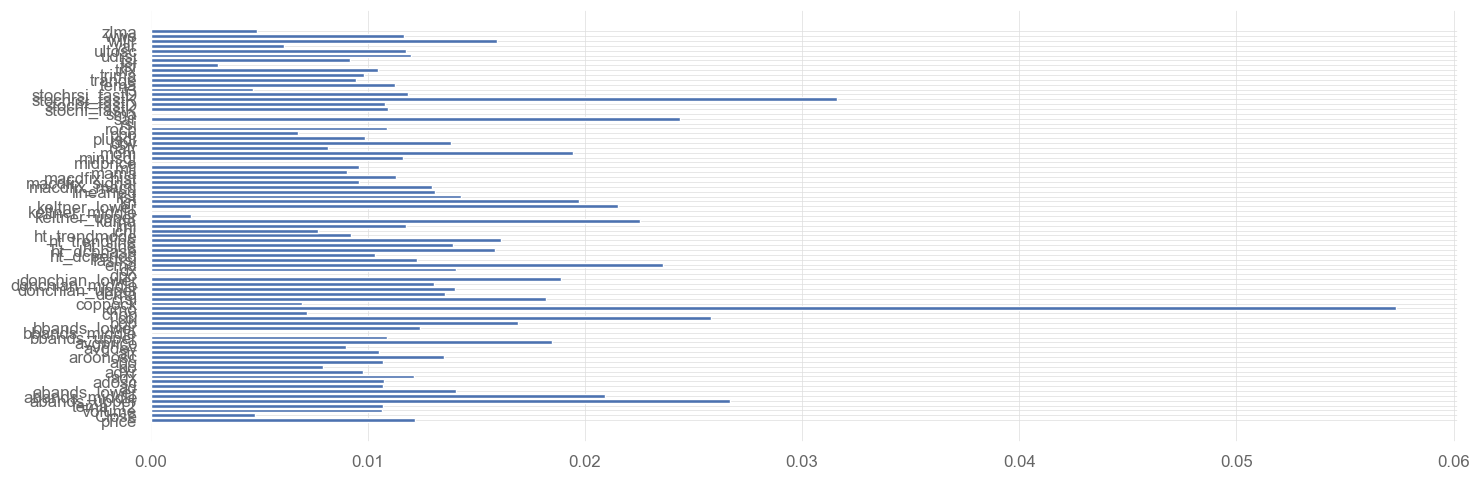

In [39]:
# Plot Feature Importances
fig = plt.figure(figsize=(15, 5))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_
plt.barh(importance_labels, importance_features)
plt.tight_layout()  # Adjust layout to fit
plt.show()

In [40]:
mean_feature_importance = importance_features.mean()*1.5
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

In [41]:
import ast

tuple_list = []
for item in recommended_feature_labels:
    if item.startswith("(") and item.endswith(")"):
        # It's a tuple representation, evaluate it
        try:
            evaluated_item = ast.literal_eval(item)
            tuple_list.append(evaluated_item)
        except ValueError as e:
            print(f"Skipping item {item}: {e}")
    else:
        # It's a simple string, use it directly
        tuple_list.append(item)

print(tuple_list)

['abands_upper', 'abands_middle', 'cci', 'cmo', 'donchian_lower', 'ema', 'kama', 'keltner_lower', 'kri', 'mom', 'sar', 'stochrsi_fastK']


In [42]:
import json

# Assuming tuple_list is already defined and filled with your data
with open('tuple_list.json', 'w') as f:
    # Convert the tuples to lists because tuples are not JSON serializable
    json.dump([list(item) if isinstance(item, tuple) else item for item in tuple_list], f)


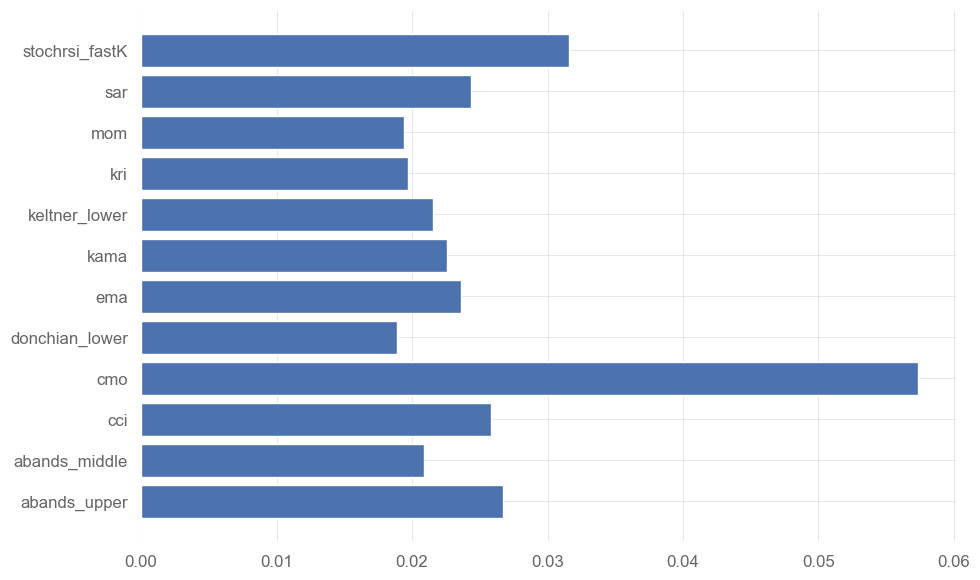

In [43]:
# Plot Recommended Features
fig = plt.figure(figsize=(10, 6))
plt.barh(recommended_feature_labels, recommended_feature_score)
plt.tight_layout()  # Adjust layout to fit
plt.show()
